In [1]:
# DASK client set

import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

# get path for path changes in Jupyter notebook: File - Open from Path - insert relative_path
notebook_path = os.path.abspath(".")
_, _, relative_path = notebook_path.partition('/all/')
relative_path = '/all/' + relative_path
relative_path

'/all/Model/CESM2/Earth_System_Predictability/DIC'

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
from scipy.interpolate import griddata
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_NWP_preprocessing import CESM2_NWP_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

In [5]:
# 1. TAUX (Total)
cfg_var_TAUX=CESM2_NWP_config()
cfg_var_TAUX.year_s=1955
cfg_var_TAUX.year_e=2020
cfg_var_TAUX.setvar('TAUX', 'ocn')
# cfg_var_TAUY.comp='ocn'
# 1. TAUY (Total)
cfg_var_TAUY=CESM2_NWP_config()
cfg_var_TAUY.year_s=1955
cfg_var_TAUY.year_e=2020
cfg_var_TAUY.setvar('TAUY', 'ocn')
# cfg_var_TAUY.comp='ocn'
ds_grid = pop_tools.get_grid('POP_gx1v7')

In [17]:
# define preprocessing function

exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', cfg_var_TAUX.var, cfg_var_TAUY.var]
# exceptcv=['time','lon','lat','lev', 'TAREA', 'TLONG', 'TLAT', 'z_t', 'dz', 'z_t_2', cfg_var_DIC.var, cfg_var_TEMP.var]

def process_coords_3d(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        # ds = ds.isel(z_t=slice(0, 39)) # ~39 layer (1000m)
        # ds = (ds.isel(z_t=slice(1, 39)) * ds.dz).sum(dim='z_t') / ds.dz.sum(dim='z_t')
        return ds
    else:
        return ds.set_coords(coord_vars)



def process_coords_3d_LE(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """
    Preprocessor function for CESM POP-style datasets.
    - Normalizes vertical coordinate: if z_t or z_t_2 exists, rename to 'depth'.
    - Replaces its values with z_t_new for consistency.
    - Optionally drops unnecessary coordinate variables for faster concatenation.
    """
    z_t_new = np.array([5.0000000e+00, 1.5000000e+01, 2.5000000e+01, 3.5000000e+01,
       4.5000000e+01, 5.5000000e+01, 6.5000000e+01, 7.5000000e+01,
       8.5000000e+01, 9.5000000e+01, 1.0500000e+02, 1.1500000e+02,
       1.2500000e+02, 1.3500000e+02, 1.4500000e+02, 1.5500000e+02,
       1.6509839e+02, 1.7547903e+02, 1.8629126e+02, 1.9766026e+02,
       2.0971138e+02, 2.2257828e+02, 2.3640883e+02, 2.5137015e+02,
       2.6765421e+02, 2.8548364e+02, 3.0511920e+02, 3.2686798e+02,
       3.5109348e+02, 3.7822760e+02, 4.0878464e+02, 4.4337769e+02,
       4.8273669e+02, 5.2772797e+02, 5.7937286e+02, 6.3886261e+02,
       7.0756329e+02, 7.8700250e+02, 8.7882520e+02, 9.8470581e+02,
       1.1062042e+03, 1.2445669e+03, 1.4004972e+03, 1.5739464e+03,
       1.7640033e+03, 1.9689442e+03, 2.1864565e+03, 2.4139714e+03,
       2.6490012e+03, 2.8893845e+03, 3.1334045e+03, 3.3797935e+03,
       3.6276702e+03, 3.8764519e+03, 4.1257681e+03, 4.3753926e+03,
       4.6251904e+03, 4.8750835e+03, 5.1250278e+03, 5.3750000e+03])
    
    # ------------------------------------------------------
    # 1️⃣ Normalize vertical coordinate name
    # ------------------------------------------------------
    if "z_t_2" in ds.dims:
        ds = ds.rename({"z_t_2": "depth"})
    elif "z_t" in ds.dims:
        ds = ds.rename({"z_t": "depth"})
    else:
        print("[Warning] No vertical coordinate (z_t or z_t_2) found — skipped.")
        return ds

    # Drop any leftover z_t/z_t_2 coordinate variable if it exists
    ds = ds.drop_vars(["z_t", "z_t_2"], errors="ignore")

    # ------------------------------------------------------
    # 2️⃣ Replace coordinate values with z_t_new
    # ------------------------------------------------------
    if "depth" in ds.coords:
        if len(ds["depth"]) == len(z_t_new):
            ds = ds.assign_coords(depth=z_t_new)
        else:
            print(f"[Warning] depth length mismatch: {len(ds['depth'])} vs {len(z_t_new)}")
    else:
        print("[Warning] depth coordinate missing after renaming.")

    # ------------------------------------------------------
    # 3️⃣ Clean up coordinate references inside variable attributes
    # ------------------------------------------------------
    for v in ds.data_vars:
        if "coordinates" in ds[v].attrs:
            ds[v].attrs["coordinates"] = (
                ds[v].attrs["coordinates"]
                .replace("z_t_2", "depth")
                .replace("z_t", "depth")
            )

    # ------------------------------------------------------
    # 4️⃣ Drop unnecessary coordinate variables and slice time
    # ------------------------------------------------------
    coord_vars = []
    for v in np.array(ds.coords):
        if v not in except_coord_vars:
            coord_vars.append(v)
    for v in np.array(ds.data_vars):
        if v not in except_coord_vars:
            coord_vars.append(v)

    if drop:
        ds = ds.drop(coord_vars, errors="ignore")
        ds = ds.sel(time=slice(sd, ed))
    else:
        ds = ds.set_coords(coord_vars)

    return ds



# exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_t', cfg_var_DIC.var, cfg_var_Li_diat.var, cfg_var_Li_sp.var,
#          cfg_var_Vi_diat_Fe.var, cfg_var_Vi_diat_N.var, cfg_var_Vi_diat_P.var, cfg_var_Vi_diat_SiO3.var,
#          cfg_var_Vi_sp_Fe.var, cfg_var_Vi_sp_N.var, cfg_var_Vi_sp_P.var,
#          cfg_var_NPP_diat.var, cfg_var_NPP_sp.var]
# def process_coords(ds, sd, ed, drop=True, except_coord_vars=exceptcv):
#     """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
#     coord_vars = []
#     for v in np.array(ds.coords) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
#     for v in np.array(ds.data_vars) :
#         if not v in except_coord_vars:
#             coord_vars += [v]
    
#     if drop:
#         ds= ds.drop(coord_vars)
#         ds= ds.sel(time=slice(sd, ed))
#         return ds
#     else:
#         return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_TAUX.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_TAUY.year_e+1, 1, 1)


# ds = ds.isel(lev=slice(1, 11))

In [12]:
cfg_var_TAUX.LE_file_list[0][11:12]

[['/mnt/lustre/proj/earth.system.predictability/LENS2/archive_region_transfer/ocn/TAUX/b.e21.BHISTsmbb.f09_g17.LE2-1231.012/NWP/NWP_b.e21.BHISTsmbb.f09_g17.LE2-1231.012.pop.h.TAUX.195001-195912.nc',
  '/mnt/lustre/proj/earth.system.predictability/LENS2/archive_region_transfer/ocn/TAUX/b.e21.BHISTsmbb.f09_g17.LE2-1231.012/NWP/NWP_b.e21.BHISTsmbb.f09_g17.LE2-1231.012.pop.h.TAUX.196001-196912.nc',
  '/mnt/lustre/proj/earth.system.predictability/LENS2/archive_region_transfer/ocn/TAUX/b.e21.BHISTsmbb.f09_g17.LE2-1231.012/NWP/NWP_b.e21.BHISTsmbb.f09_g17.LE2-1231.012.pop.h.TAUX.197001-197912.nc',
  '/mnt/lustre/proj/earth.system.predictability/LENS2/archive_region_transfer/ocn/TAUX/b.e21.BHISTsmbb.f09_g17.LE2-1231.012/NWP/NWP_b.e21.BHISTsmbb.f09_g17.LE2-1231.012.pop.h.TAUX.198001-198912.nc',
  '/mnt/lustre/proj/earth.system.predictability/LENS2/archive_region_transfer/ocn/TAUX/b.e21.BHISTsmbb.f09_g17.LE2-1231.012/NWP/NWP_b.e21.BHISTsmbb.f09_g17.LE2-1231.012.pop.h.TAUX.199001-199912.nc',
  '/m

In [19]:
# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#TAUX
cfg_var_TAUX.ADA_path_load(cfg_var_TAUX.var)
cfg_var_TAUX.ADA_ds = xr.open_mfdataset(cfg_var_TAUX.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUX.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TAUX.ADA_ds = cfg_var_TAUX.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TAUX.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUX.ADA_ds.time))
cfg_var_TAUX.ADA_ds = cfg_var_TAUX.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))


# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TAUX
cfg_var_TAUX.WDA_path_load(cfg_var_TAUX.var)
cfg_var_TAUX.WDA_ds = xr.open_mfdataset(cfg_var_TAUX.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUX.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TAUX.WDA_ds = cfg_var_TAUX.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_TAUX.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUX.WDA_ds.time))
cfg_var_TAUX.WDA_ds = cfg_var_TAUX.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))


# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TAUX
cfg_var_TAUX.ODA_path_load(cfg_var_TAUX.var)
cfg_var_TAUX.ODA_ds = xr.open_mfdataset(cfg_var_TAUX.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUX.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TAUX.ODA_ds = cfg_var_TAUX.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_TAUX.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUX.ODA_ds.time))
cfg_var_TAUX.ODA_ds = cfg_var_TAUX.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



#LE TAUX
start_time = time.time()
cfg_var_TAUX.LE_path_load(cfg_var_TAUX.var)
cfg_var_TAUX.LE_ds = xr.open_mfdataset(cfg_var_TAUX.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUX.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TAUX.LE_ds = cfg_var_TAUX.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TAUX.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUX.LE_ds.time))
cfg_var_TAUX.LE_ds = cfg_var_TAUX.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# cfg_var_TAUX.ODA_path_load(cfg_var_TAUX.var)
# cfg_var_TAUX.ODA_file_list[0]

#regrids
import xcesm

# cfg_var_TAUX.ODA_ds_rgd = cfg_var_TAUX.ODA_ds['TAUX'].isel(ens_ODA=5).utils.regrid()
# cfg_var_TAUX.ADA_ds_rgd = cfg_var_TAUX.ADA_ds['TAUX'].isel(ens_ADA=5).utils.regrid()
# cfg_var_TAUX.WDA_ds_rgd = cfg_var_TAUX.WDA_ds['TAUX'].isel(ens_WDA=0).utils.regrid()

lat_range = slice(10, 60)
lon_range = slice(110, 190)

start_time = time.time()

cfg_var_TAUX.ODA_ds_rgd = (
    cfg_var_TAUX.ODA_ds['TAUX']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ODA: ' + str(elapsed_time))

cfg_var_TAUX.ADA_ds_rgd = (
    cfg_var_TAUX.ADA_ds['TAUX']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ADA: ' + str(elapsed_time))

cfg_var_TAUX.WDA_ds_rgd = (
    cfg_var_TAUX.WDA_ds['TAUX']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding WDA: ' + str(elapsed_time))

cfg_var_TAUX.LE_ds_rgd = (
    cfg_var_TAUX.LE_ds['TAUX']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding LE: ' + str(elapsed_time))

cfg_var_TAUX.WDA_ds_rgd = cfg_var_TAUX.WDA_ds_rgd.sortby("time")
cfg_var_TAUX.ADA_ds_rgd = cfg_var_TAUX.ADA_ds_rgd.sortby("time")
cfg_var_TAUX.ODA_ds_rgd = cfg_var_TAUX.ODA_ds_rgd.sortby("time")
cfg_var_TAUX.LE_ds_rgd = cfg_var_TAUX.LE_ds_rgd.sortby("time")

elasped time for reading ADA: 4.1190948486328125
elasped time for reading WDA: 1.8228843212127686
elasped time for reading ODA: 2.0003814697265625
elasped time for reading LE: 1.6060419082641602
elasped time for regriding ODA: 6.1605002880096436
elasped time for regriding ADA: 7.700733423233032
elasped time for regriding WDA: 9.220658779144287
elasped time for regriding LE: 10.573315620422363


In [20]:
# Read ADA dataset

# Quicker test for 2 ensembADAs only

start_time = time.time()

#TAUY
cfg_var_TAUY.ADA_path_load(cfg_var_TAUY.var)
cfg_var_TAUY.ADA_ds = xr.open_mfdataset(cfg_var_TAUY.ADA_file_list[0][5:6], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUY.ADA_ensembles][5:6], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TAUY.ADA_ds = cfg_var_TAUY.ADA_ds.rename({"concat_dim": "ens_ADA"})
new_time = cfg_var_TAUY.ADA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUY.ADA_ds.time))
cfg_var_TAUY.ADA_ds = cfg_var_TAUY.ADA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ADA: ' + str(elapsed_time))


# Read WDA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TAUY
cfg_var_TAUY.WDA_path_load(cfg_var_TAUY.var)
cfg_var_TAUY.WDA_ds = xr.open_mfdataset(cfg_var_TAUY.WDA_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUY.WDA_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TAUY.WDA_ds = cfg_var_TAUY.WDA_ds.rename({"concat_dim": "ens_WDA"})
new_time = cfg_var_TAUY.WDA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUY.WDA_ds.time))
cfg_var_TAUY.WDA_ds = cfg_var_TAUY.WDA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading WDA: ' + str(elapsed_time))


# Read ODA dataset

# Quicker test for 2 ensembles only

start_time = time.time()

#TAUY
cfg_var_TAUY.ODA_path_load(cfg_var_TAUY.var)
cfg_var_TAUY.ODA_ds = xr.open_mfdataset(cfg_var_TAUY.ODA_file_list[0][15:16], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUY.ODA_ensembles][15:16], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TAUY.ODA_ds = cfg_var_TAUY.ODA_ds.rename({"concat_dim": "ens_ODA"})
new_time = cfg_var_TAUY.ODA_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUY.ODA_ds.time))
cfg_var_TAUY.ODA_ds = cfg_var_TAUY.ODA_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading ODA: ' + str(elapsed_time))



#LE TAUY
start_time = time.time()
cfg_var_TAUY.LE_path_load(cfg_var_TAUY.var)
cfg_var_TAUY.LE_ds = xr.open_mfdataset(cfg_var_TAUY.LE_file_list[0][11:12], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TAUY.LE_ensembles][11:12], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords_3d(ds, start_date, end_date),
                       decode_cf=True, 
                       decode_times=True)         

cfg_var_TAUY.LE_ds = cfg_var_TAUY.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TAUY.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TAUY.LE_ds.time))
cfg_var_TAUY.LE_ds = cfg_var_TAUY.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

# cfg_var_TAUY.ODA_path_load(cfg_var_TAUY.var)
# cfg_var_TAUY.ODA_file_list[0]

#regrids
import xcesm

# cfg_var_TAUY.ODA_ds_rgd = cfg_var_TAUY.ODA_ds['TAUY'].isel(ens_ODA=5).utils.regrid()
# cfg_var_TAUY.ADA_ds_rgd = cfg_var_TAUY.ADA_ds['TAUY'].isel(ens_ADA=5).utils.regrid()
# cfg_var_TAUY.WDA_ds_rgd = cfg_var_TAUY.WDA_ds['TAUY'].isel(ens_WDA=0).utils.regrid()

lat_range = slice(10, 60)
lon_range = slice(110, 190)

start_time = time.time()

cfg_var_TAUY.ODA_ds_rgd = (
    cfg_var_TAUY.ODA_ds['TAUY']
    .isel(ens_ODA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)
end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ODA: ' + str(elapsed_time))

cfg_var_TAUY.ADA_ds_rgd = (
    cfg_var_TAUY.ADA_ds['TAUY']
    .isel(ens_ADA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding ADA: ' + str(elapsed_time))

cfg_var_TAUY.WDA_ds_rgd = (
    cfg_var_TAUY.WDA_ds['TAUY']
    .isel(ens_WDA=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding WDA: ' + str(elapsed_time))

cfg_var_TAUY.LE_ds_rgd = (
    cfg_var_TAUY.LE_ds['TAUY']
    .isel(ens_LE=0)
    .utils.regrid()
    .sel(lat=lat_range, lon=lon_range)
)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for regriding LE: ' + str(elapsed_time))

cfg_var_TAUY.WDA_ds_rgd = cfg_var_TAUY.WDA_ds_rgd.sortby("time")
cfg_var_TAUY.ADA_ds_rgd = cfg_var_TAUY.ADA_ds_rgd.sortby("time")
cfg_var_TAUY.ODA_ds_rgd = cfg_var_TAUY.ODA_ds_rgd.sortby("time")
cfg_var_TAUY.LE_ds_rgd = cfg_var_TAUY.LE_ds_rgd.sortby("time")

elasped time for reading ADA: 1.9037249088287354
elasped time for reading WDA: 2.410431385040283
elasped time for reading ODA: 2.0139853954315186
elasped time for reading LE: 1.864121913909912
elasped time for regriding ODA: 1.4435200691223145
elasped time for regriding ADA: 2.932405710220337
elasped time for regriding WDA: 4.362780570983887
elasped time for regriding LE: 5.62642765045166


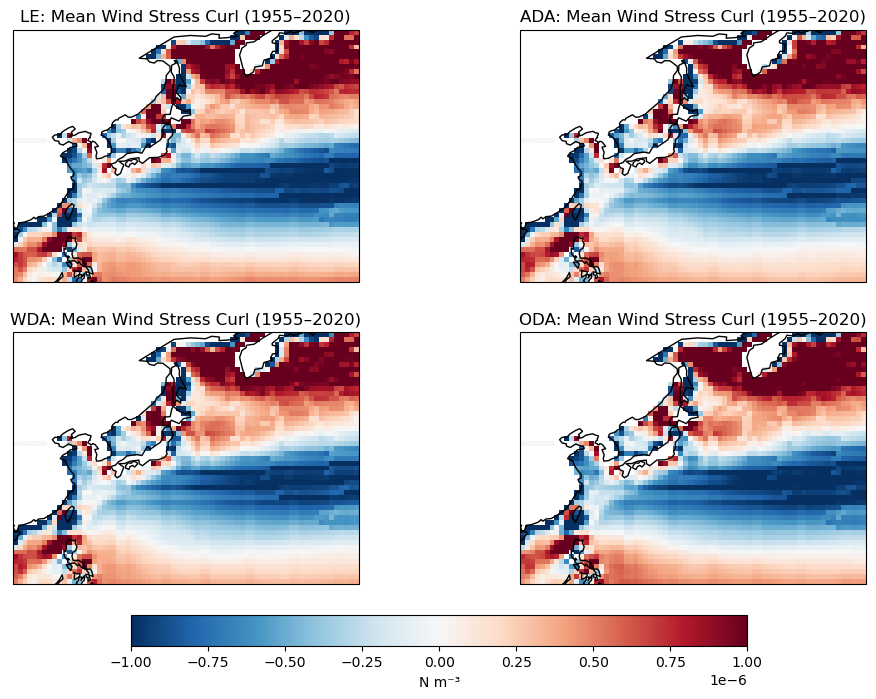

In [26]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Function: compute wind stress curl
# ==========================================================
def compute_tau_curl(ds_taux, ds_tauy):
    """
    Compute surface wind stress curl: (dTAUY/dx - dTAUX/dy)
    Handles 2D metric correction for latitude/longitude grids.
    Output units ~ [N m^-3].
    """
    Re = 6.371e6  # Earth radius [m]

    # Extract coordinates
    lat = ds_taux.lat
    lon = ds_taux.lon

    # Convert to radians for metric terms
    deg2rad = np.pi / 180.0
    coslat = np.cos(lat * deg2rad)

    # Compute 1D spacing
    dlat = np.gradient(lat)
    dlon = np.gradient(lon)

    # Convert 1D numpy arrays → DataArray for broadcasting
    dlat_da = xr.DataArray(dlat, coords={"lat": lat}, dims=["lat"])
    dlon_da = xr.DataArray(dlon, coords={"lon": lon}, dims=["lon"])
    coslat_da = xr.DataArray(coslat, coords={"lat": lat}, dims=["lat"])

    # Compute metric factors (broadcast to 2D)
    dy = (dlat_da * deg2rad * Re).broadcast_like(ds_taux)
    dx = ((dlon_da * deg2rad * Re) * coslat_da).broadcast_like(ds_taux)

    # Partial derivatives
    dTAUY_dx = ds_tauy.differentiate("lon") / dx
    dTAUX_dy = ds_taux.differentiate("lat") / dy

    # Curl
    curl = dTAUY_dx - dTAUX_dy
    curl.attrs["long_name"] = "Surface wind stress curl"
    curl.attrs["units"] = "N m^-3"
    return curl


# ==========================================================
# 2) Compute curl for each experiment
# ==========================================================
curl_LE  = compute_tau_curl(cfg_var_TAUX.LE_ds_rgd,  cfg_var_TAUY.LE_ds_rgd)
curl_ADA = compute_tau_curl(cfg_var_TAUX.ADA_ds_rgd, cfg_var_TAUY.ADA_ds_rgd)
curl_WDA = compute_tau_curl(cfg_var_TAUX.WDA_ds_rgd, cfg_var_TAUY.WDA_ds_rgd)
curl_ODA = compute_tau_curl(cfg_var_TAUX.ODA_ds_rgd, cfg_var_TAUY.ODA_ds_rgd)


# ==========================================================
# 3) Helper: compute long-term mean (1955–2020)
# ==========================================================
def get_longterm_mean(ds, start_year=1955, end_year=2020):
    """Return time mean over a given year range."""
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")


curl_means = {
    "LE":  get_longterm_mean(curl_LE),
    "ADA": get_longterm_mean(curl_ADA),
    "WDA": get_longterm_mean(curl_WDA),
    "ODA": get_longterm_mean(curl_ODA),
}


# ==========================================================
# 4) Plot 2×2 panels: mean wind stress curl (1955–2020)
# ==========================================================
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax, (name, da) in zip(axes.flat, curl_means.items()):
    p = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=-1e-6, vmax=1e-6,
        add_colorbar=False
    )
    ax.coastlines()
    ax.set_title(f"{name}: Mean Wind Stress Curl (1955–2020)")

# Shared colorbar
cbar = fig.colorbar(
    p, ax=axes, orientation="horizontal",
    fraction=0.05, pad=0.05, label="N m⁻³"
)

# plt.tight_layout()
plt.show()


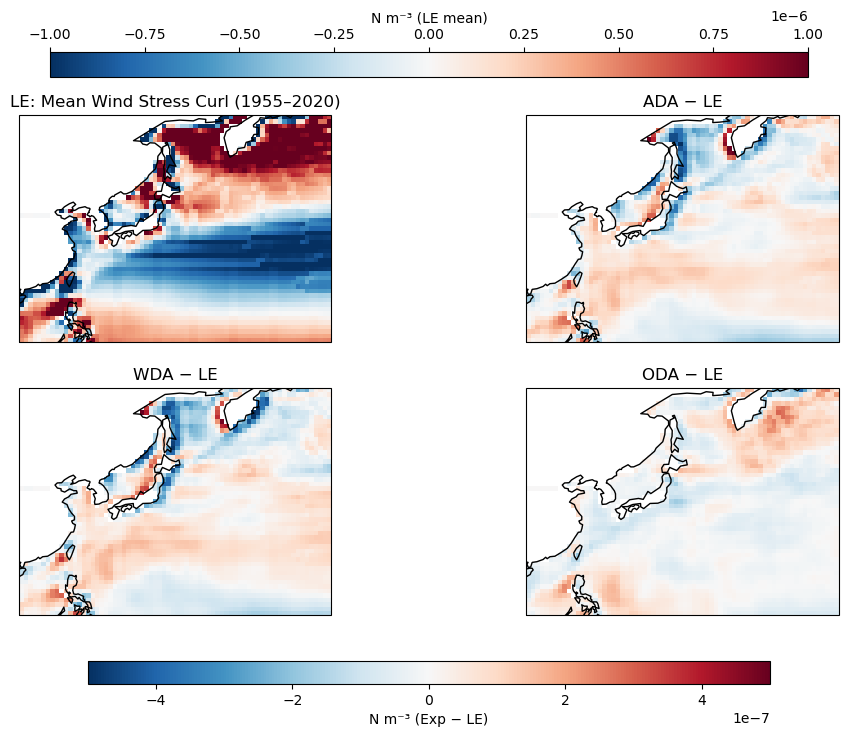

In [45]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Compute curl function (동일)
# ==========================================================
def compute_tau_curl(ds_taux, ds_tauy):
    Re = 6.371e6
    lat, lon = ds_taux.lat, ds_taux.lon
    deg2rad = np.pi / 180.0
    coslat = np.cos(lat * deg2rad)
    dlat, dlon = np.gradient(lat), np.gradient(lon)

    dlat_da = xr.DataArray(dlat, coords={"lat": lat}, dims=["lat"])
    dlon_da = xr.DataArray(dlon, coords={"lon": lon}, dims=["lon"])
    coslat_da = xr.DataArray(coslat, coords={"lat": lat}, dims=["lat"])

    dy = (dlat_da * deg2rad * Re).broadcast_like(ds_taux)
    dx = ((dlon_da * deg2rad * Re) * coslat_da).broadcast_like(ds_taux)

    dTAUY_dx = ds_tauy.differentiate("lon") / dx
    dTAUX_dy = ds_taux.differentiate("lat") / dy
    curl = dTAUY_dx - dTAUX_dy
    curl.attrs["long_name"] = "Surface wind stress curl"
    curl.attrs["units"] = "N m^-3"
    return curl

# ==========================================================
# 2) Compute and mean fields (간단히 예시)
# ==========================================================
curl_LE  = compute_tau_curl(cfg_var_TAUX.LE_ds_rgd,  cfg_var_TAUY.LE_ds_rgd)
curl_ADA = compute_tau_curl(cfg_var_TAUX.ADA_ds_rgd, cfg_var_TAUY.ADA_ds_rgd)
curl_WDA = compute_tau_curl(cfg_var_TAUX.WDA_ds_rgd, cfg_var_TAUY.WDA_ds_rgd)
curl_ODA = compute_tau_curl(cfg_var_TAUX.ODA_ds_rgd, cfg_var_TAUY.ODA_ds_rgd)

def get_longterm_mean(ds, start_year=1955, end_year=2020):
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")

mean_LE  = get_longterm_mean(curl_LE)
mean_ADA = get_longterm_mean(curl_ADA)
mean_WDA = get_longterm_mean(curl_WDA)
mean_ODA = get_longterm_mean(curl_ODA)

anom_ADA = mean_ADA - mean_LE
anom_WDA = mean_WDA - mean_LE
anom_ODA = mean_ODA - mean_LE

# ==========================================================
# 3) Plot
# ==========================================================
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# ---------- (1,1) LE mean ----------
p0 = mean_LE.plot(
    ax=axes[0,0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-1e-6, vmax=1e-6,
    add_colorbar=False
)
axes[0,0].coastlines()
axes[0,0].set_title("LE: Mean Wind Stress Curl (1955–2020)")

# ---------- (1,2) ADA − LE ----------
p1 = anom_ADA.plot(ax=axes[0,1], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-5e-7, vmax=5e-7, add_colorbar=False)
axes[0,1].coastlines(); axes[0,1].set_title("ADA − LE")

# ---------- (2,1) WDA − LE ----------
p2 = anom_WDA.plot(ax=axes[1,0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-5e-7, vmax=5e-7, add_colorbar=False)
axes[1,0].coastlines(); axes[1,0].set_title("WDA − LE")

# ---------- (2,2) ODA − LE ----------
p3 = anom_ODA.plot(ax=axes[1,1], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-5e-7, vmax=5e-7, add_colorbar=False)
axes[1,1].coastlines(); axes[1,1].set_title("ODA − LE")

# ==========================================================
# 4) Colorbars (위쪽 / 아래쪽)
# ==========================================================

# 4-1️⃣ 상단 바깥쪽 colorbar (LE mean)
plt.subplots_adjust(top=0.9)  # 위쪽 여백 확보
cbar_top = fig.colorbar(
    p0, ax=axes.ravel().tolist(), orientation="horizontal",
    fraction=0.04, pad=0.06, aspect=30, location="top", use_gridspec=True
)
cbar_top.set_label("N m⁻³ (LE mean)")
cbar_top.ax.xaxis.set_label_position('top')
cbar_top.ax.xaxis.set_ticks_position('top')

# 4-2️⃣ 하단 바깥쪽 colorbar (anomalies)
cbar_bottom = fig.colorbar(
    p3, ax=axes.ravel().tolist(), orientation="horizontal",
    fraction=0.04, pad=0.08, aspect=30
)
cbar_bottom.set_label("N m⁻³ (Exp − LE)")

plt.show()


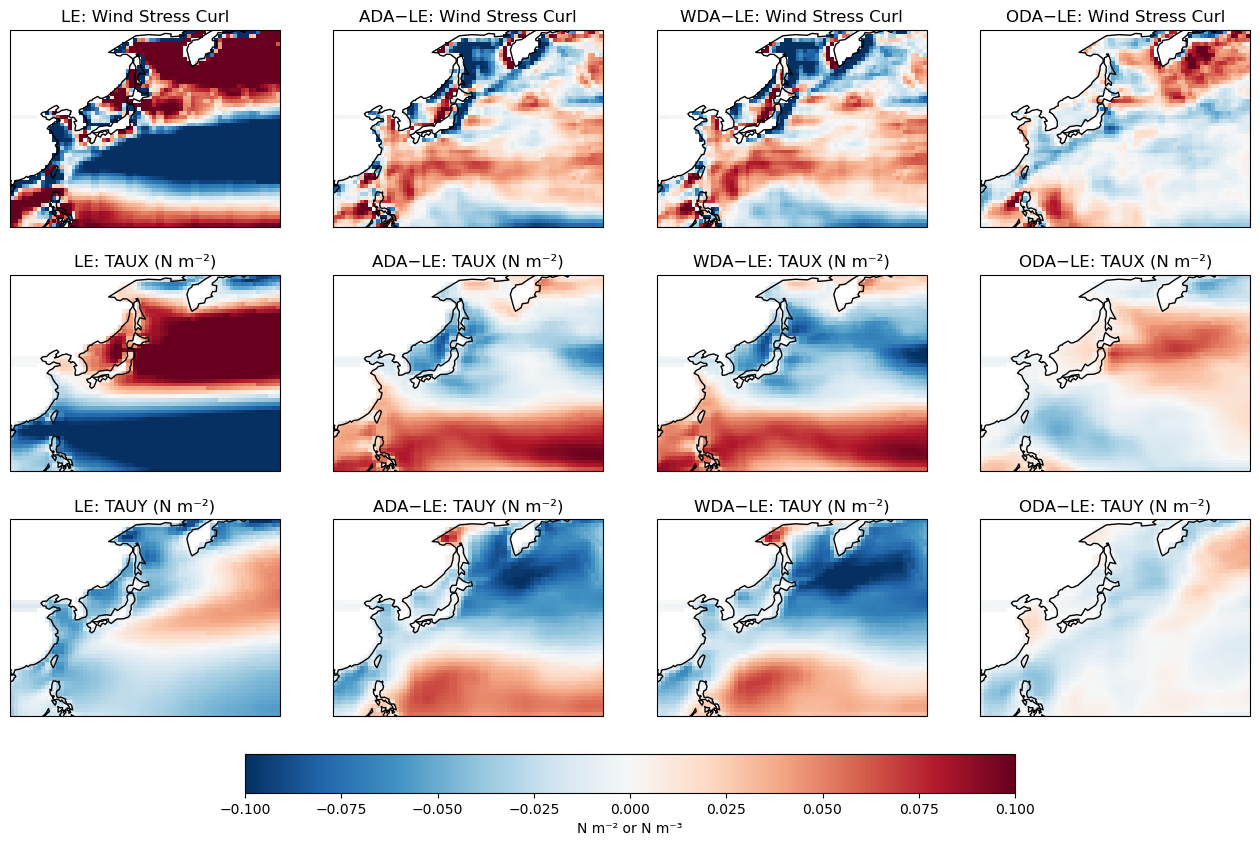

In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Helper: compute long-term mean (1955–2020)
# ==========================================================
def get_longterm_mean(ds, start_year=1955, end_year=2020):
    """Return time mean over a given year range."""
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")

# ==========================================================
# 2) Compute long-term means for TAUX and TAUY
# ==========================================================
meanx_LE  = get_longterm_mean(cfg_var_TAUX.LE_ds_rgd)
meanx_ADA = get_longterm_mean(cfg_var_TAUX.ADA_ds_rgd)
meanx_WDA = get_longterm_mean(cfg_var_TAUX.WDA_ds_rgd)
meanx_ODA = get_longterm_mean(cfg_var_TAUX.ODA_ds_rgd)

meany_LE  = get_longterm_mean(cfg_var_TAUY.LE_ds_rgd)
meany_ADA = get_longterm_mean(cfg_var_TAUY.ADA_ds_rgd)
meany_WDA = get_longterm_mean(cfg_var_TAUY.WDA_ds_rgd)
meany_ODA = get_longterm_mean(cfg_var_TAUY.ODA_ds_rgd)

# Compute anomalies (Exp − LE)
anomx_ADA = meanx_ADA - meanx_LE
anomx_WDA = meanx_WDA - meanx_LE
anomx_ODA = meanx_ODA - meanx_LE

anomy_ADA = meany_ADA - meany_LE
anomy_WDA = meany_WDA - meany_LE
anomy_ODA = meany_ODA - meany_LE


# ==========================================================
# 3) Plot 3×4 panels (rows: curl, TAUX, TAUY)
# ==========================================================
fig, axes = plt.subplots(
    nrows=3, ncols=4, figsize=(16, 10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# =========================
# Row 1: Wind Stress Curl
# =========================
curl_LE_mean  = get_longterm_mean(curl_LE)
curl_ADA_mean = get_longterm_mean(curl_ADA)
curl_WDA_mean = get_longterm_mean(curl_WDA)
curl_ODA_mean = get_longterm_mean(curl_ODA)

curl_ADA_anom = curl_ADA_mean - curl_LE_mean
curl_WDA_anom = curl_WDA_mean - curl_LE_mean
curl_ODA_anom = curl_ODA_mean - curl_LE_mean

panels = [
    ("LE", curl_LE_mean, -5e-7, 5e-7),
    ("ADA−LE", curl_ADA_anom, -2e-7, 2e-7),
    ("WDA−LE", curl_WDA_anom, -2e-7, 2e-7),
    ("ODA−LE", curl_ODA_anom, -2e-7, 2e-7)
]

for j, (label, da, vmin, vmax) in enumerate(panels):
    p = da.plot(
        ax=axes[0, j], transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=vmin, vmax=vmax,
        add_colorbar=False
    )
    axes[0, j].coastlines()
    axes[0, j].set_title(f"{label}: Wind Stress Curl")

# =========================
# Row 2: TAUX
# =========================
panels_x = [
    ("LE", meanx_LE, -0.5, 0.5),
    ("ADA−LE", anomx_ADA, -0.1, 0.1),
    ("WDA−LE", anomx_WDA, -0.1, 0.1),
    ("ODA−LE", anomx_ODA, -0.1, 0.1)
]

for j, (label, da, vmin, vmax) in enumerate(panels_x):
    p = da.plot(
        ax=axes[1, j], transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=vmin, vmax=vmax,
        add_colorbar=False
    )
    axes[1, j].coastlines()
    axes[1, j].set_title(f"{label}: TAUX (N m⁻²)")

# =========================
# Row 3: TAUY
# =========================
panels_y = [
    ("LE", meany_LE, -0.5, 0.5),
    ("ADA−LE", anomy_ADA, -0.1, 0.1),
    ("WDA−LE", anomy_WDA, -0.1, 0.1),
    ("ODA−LE", anomy_ODA, -0.1, 0.1)
]

for j, (label, da, vmin, vmax) in enumerate(panels_y):
    p = da.plot(
        ax=axes[2, j], transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=vmin, vmax=vmax,
        add_colorbar=False
    )
    axes[2, j].coastlines()
    axes[2, j].set_title(f"{label}: TAUY (N m⁻²)")

# # Shared colorbar for the bottom row
# cbar = fig.colorbar(
#     p, ax=axes, orientation="horizontal",
#     fraction=0.05, pad=0.05, label="N m⁻² or N m⁻³"
# )

# plt.tight_layout()
plt.show()


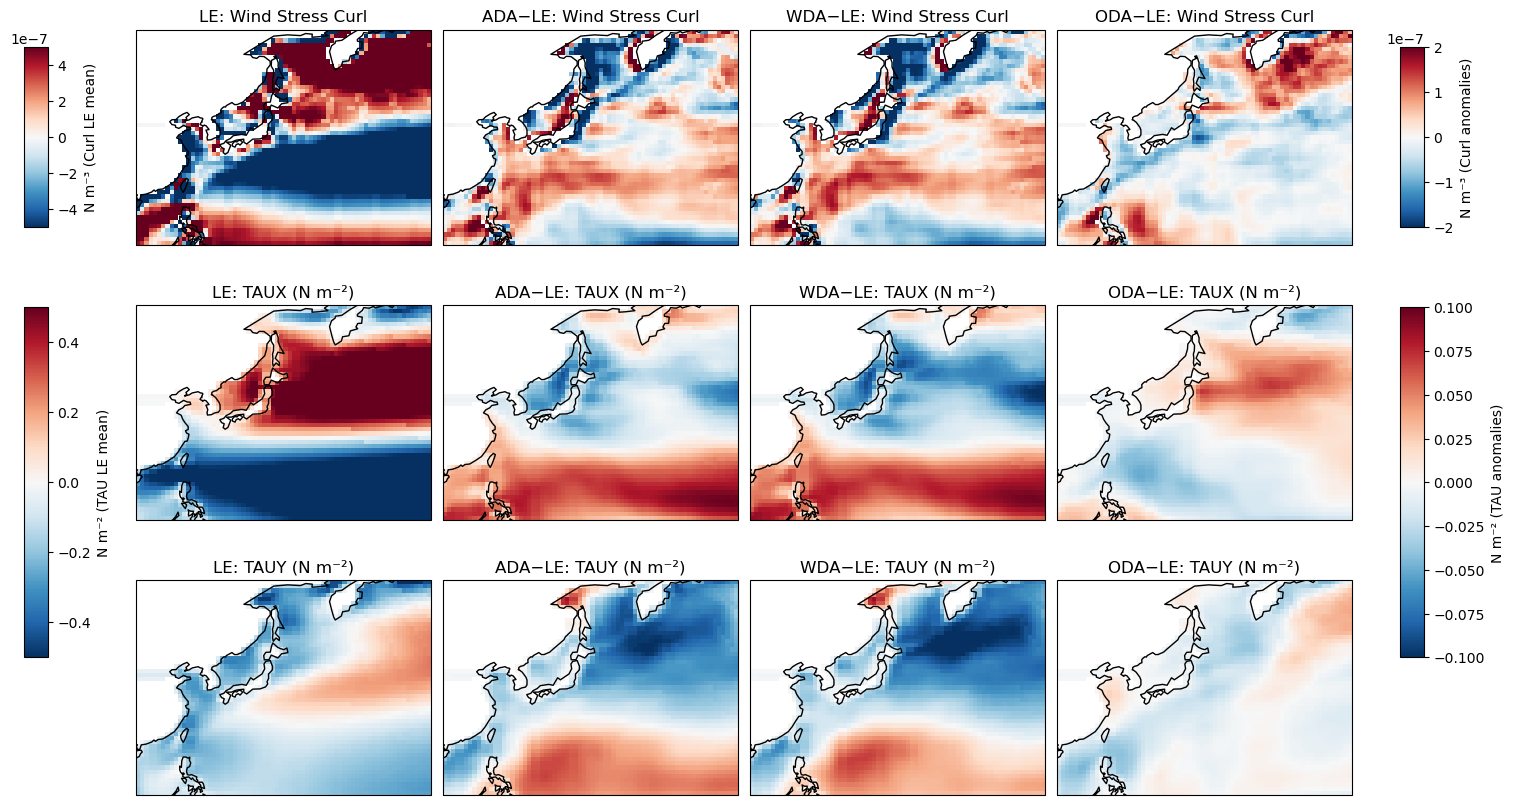

In [50]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Helper: compute long-term mean (1955–2020)
# ==========================================================
def get_longterm_mean(ds, start_year=1955, end_year=2020):
    """Return time mean over a given year range."""
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")


# ==========================================================
# 2) Compute long-term means for TAUX, TAUY, and Curl
# ==========================================================
meanx_LE  = get_longterm_mean(cfg_var_TAUX.LE_ds_rgd)
meanx_ADA = get_longterm_mean(cfg_var_TAUX.ADA_ds_rgd)
meanx_WDA = get_longterm_mean(cfg_var_TAUX.WDA_ds_rgd)
meanx_ODA = get_longterm_mean(cfg_var_TAUX.ODA_ds_rgd)

meany_LE  = get_longterm_mean(cfg_var_TAUY.LE_ds_rgd)
meany_ADA = get_longterm_mean(cfg_var_TAUY.ADA_ds_rgd)
meany_WDA = get_longterm_mean(cfg_var_TAUY.WDA_ds_rgd)
meany_ODA = get_longterm_mean(cfg_var_TAUY.ODA_ds_rgd)

# Compute anomalies (Exp − LE)
anomx_ADA = meanx_ADA - meanx_LE
anomx_WDA = meanx_WDA - meanx_LE
anomx_ODA = meanx_ODA - meanx_LE

anomy_ADA = meany_ADA - meany_LE
anomy_WDA = meany_WDA - meany_LE
anomy_ODA = meany_ODA - meany_LE

# Curl means & anomalies
curl_LE_mean  = get_longterm_mean(curl_LE)
curl_ADA_mean = get_longterm_mean(curl_ADA)
curl_WDA_mean = get_longterm_mean(curl_WDA)
curl_ODA_mean = get_longterm_mean(curl_ODA)

curl_ADA_anom = curl_ADA_mean - curl_LE_mean
curl_WDA_anom = curl_WDA_mean - curl_LE_mean
curl_ODA_anom = curl_ODA_mean - curl_LE_mean


# ==========================================================
# 3) Plot setup (3×4 grid)
# ==========================================================
fig, axes = plt.subplots(
    nrows=3, ncols=4, figsize=(16, 10),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# -------------------------------
# Row 1: Wind Stress Curl
# -------------------------------
panels1 = [
    ("LE", curl_LE_mean, -5e-7, 5e-7),
    ("ADA−LE", curl_ADA_anom, -2e-7, 2e-7),
    ("WDA−LE", curl_WDA_anom, -2e-7, 2e-7),
    ("ODA−LE", curl_ODA_anom, -2e-7, 2e-7),
]
for j, (label, da, vmin, vmax) in enumerate(panels1):
    da.plot(ax=axes[0, j], transform=ccrs.PlateCarree(),
            cmap="RdBu_r", vmin=vmin, vmax=vmax, add_colorbar=False)
    axes[0, j].coastlines()
    axes[0, j].set_title(f"{label}: Wind Stress Curl")

# -------------------------------
# Row 2: TAUX
# -------------------------------
panels2 = [
    ("LE", meanx_LE, -0.5, 0.5),
    ("ADA−LE", anomx_ADA, -0.1, 0.1),
    ("WDA−LE", anomx_WDA, -0.1, 0.1),
    ("ODA−LE", anomx_ODA, -0.1, 0.1),
]
for j, (label, da, vmin, vmax) in enumerate(panels2):
    da.plot(ax=axes[1, j], transform=ccrs.PlateCarree(),
            cmap="RdBu_r", vmin=vmin, vmax=vmax, add_colorbar=False)
    axes[1, j].coastlines()
    axes[1, j].set_title(f"{label}: TAUX (N m⁻²)")

# -------------------------------
# Row 3: TAUY
# -------------------------------
panels3 = [
    ("LE", meany_LE, -0.5, 0.5),
    ("ADA−LE", anomy_ADA, -0.1, 0.1),
    ("WDA−LE", anomy_WDA, -0.1, 0.1),
    ("ODA−LE", anomy_ODA, -0.1, 0.1),
]
for j, (label, da, vmin, vmax) in enumerate(panels3):
    da.plot(ax=axes[2, j], transform=ccrs.PlateCarree(),
            cmap="RdBu_r", vmin=vmin, vmax=vmax, add_colorbar=False)
    axes[2, j].coastlines()
    axes[2, j].set_title(f"{label}: TAUY (N m⁻²)")

# Adjust subplot spacing
plt.subplots_adjust(left=0.12, right=0.88, wspace=0.04, hspace=0.25)

# ==========================================================
# 4) Colorbars (using fixed axes for perfect alignment)
# ==========================================================

# ----- Left-side colorbars (LE means)
cax_left_curl = fig.add_axes([0.05, 0.68, 0.015, 0.18])  # [x0, y0, width, height]
cb1 = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-5e-7, 5e-7)),
    cax=cax_left_curl, orientation="vertical"
)
cb1.set_label("N m⁻³ (Curl LE mean)")

cax_left_tau = fig.add_axes([0.05, 0.25, 0.015, 0.35])
cb2 = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-0.5, 0.5)),
    cax=cax_left_tau, orientation="vertical"
)
cb2.set_label("N m⁻² (TAU LE mean)")

# ----- Right-side colorbars (Anomalies)
cax_right_curl = fig.add_axes([0.91, 0.68, 0.015, 0.18])
cb3 = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-2e-7, 2e-7)),
    cax=cax_right_curl, orientation="vertical"
)
cb3.set_label("N m⁻³ (Curl anomalies)")

cax_right_tau = fig.add_axes([0.91, 0.25, 0.015, 0.35])
cb4 = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-0.1, 0.1)),
    cax=cax_right_tau, orientation="vertical"
)
cb4.set_label("N m⁻² (TAU anomalies)")

plt.show()


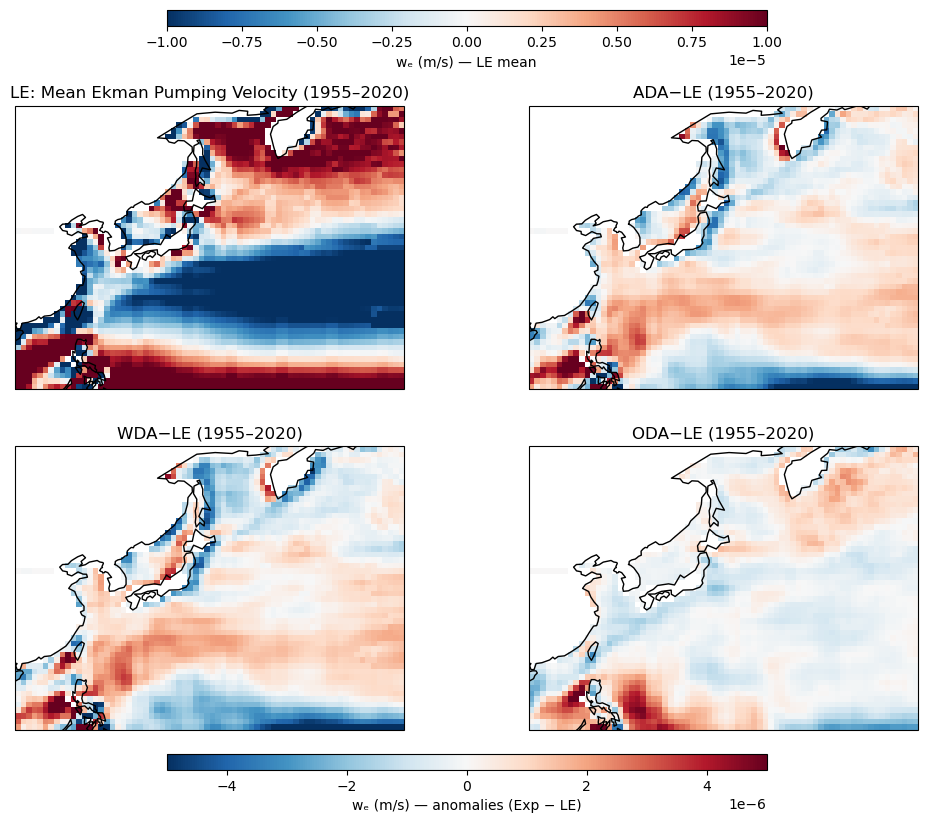

In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# ==========================================================
# 1) Compute Ekman pumping velocity from wind stress curl
# ==========================================================
def compute_ekman_pumping(curl, lat):
    """
    Convert wind stress curl (N/m^3) into Ekman pumping velocity (m/s).
    Positive = upwelling, Negative = downwelling in NH.
    """
    rho = 1025.0            # seawater density [kg/m^3]
    Omega = 7.2921e-5       # Earth's rotation rate [rad/s]
    f = 2 * Omega * np.sin(np.deg2rad(lat))
    f = xr.DataArray(f, coords={"lat": lat}, dims=["lat"])
    wE = curl / (rho * f)
    wE.attrs["long_name"] = "Ekman pumping velocity"
    wE.attrs["units"] = "m/s"
    return wE


# ==========================================================
# 2) Apply to each experiment
# ==========================================================
wE_LE  = compute_ekman_pumping(curl_LE,  curl_LE.lat)
wE_ADA = compute_ekman_pumping(curl_ADA, curl_ADA.lat)
wE_WDA = compute_ekman_pumping(curl_WDA, curl_WDA.lat)
wE_ODA = compute_ekman_pumping(curl_ODA, curl_ODA.lat)

# Long-term means
def get_longterm_mean(ds, start_year=1955, end_year=2020):
    return ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31")).mean("time")

wE_means = {
    "LE":  get_longterm_mean(wE_LE),
    "ADA": get_longterm_mean(wE_ADA),
    "WDA": get_longterm_mean(wE_WDA),
    "ODA": get_longterm_mean(wE_ODA),
}

# Anomalies (Exp − LE)
wE_anoms = {
    "ADA−LE": wE_means["ADA"] - wE_means["LE"],
    "WDA−LE": wE_means["WDA"] - wE_means["LE"],
    "ODA−LE": wE_means["ODA"] - wE_means["LE"],
}

# ==========================================================
# 3) Plot: 2×2 panels (LE mean + anomalies)
# ==========================================================
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8),
    subplot_kw={"projection": ccrs.PlateCarree()}
)

# (1,1): LE mean
wE_means["LE"].plot(
    ax=axes[0, 0], transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-1e-5, vmax=1e-5, add_colorbar=False
)
axes[0, 0].coastlines()
axes[0, 0].set_title("LE: Mean Ekman Pumping Velocity (1955–2020)")

# (1,2), (2,1), (2,2): anomalies
for ax, (name, da) in zip(axes.flat[1:], wE_anoms.items()):
    da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap="RdBu_r", vmin=-5e-6, vmax=5e-6, add_colorbar=False
    )
    ax.coastlines()
    ax.set_title(f"{name} (1955–2020)")

plt.subplots_adjust(left=0.08, right=0.92, top=0.90, bottom=0.12, wspace=0.04, hspace=0.2)

# ==========================================================
# 4) Colorbars (top: mean / bottom: anomalies)
# ==========================================================

# --- Top colorbar (LE mean) ---
cax_top = fig.add_axes([0.25, 1, 0.5, 0.02])  # [x0, y0, width, height]
cb_top = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-1e-5, 1e-5)),
    cax=cax_top, orientation="horizontal"
)
cb_top.set_label("wₑ (m/s) — LE mean")

# --- Bottom colorbar (anomalies) ---
cax_bottom = fig.add_axes([0.25, 0.07, 0.5, 0.02])
cb_bottom = plt.colorbar(
    plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(-5e-6, 5e-6)),
    cax=cax_bottom, orientation="horizontal"
)
cb_bottom.set_label("wₑ (m/s) — anomalies (Exp − LE)")

plt.show()
